In [35]:
from keras.models import Model
from keras.layers import Flatten,Dense
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plot
from glob import glob

#data Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Description of the Pneumonia Dataset


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [36]:
IMAGESHAPE = [224, 224, 3] 
training_data = '/Users/dammy/Downloads/chest_xray/train'
testing_data = '/Users/dammy/Downloads/chest_xray/test'

In [65]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [66]:
train = get_training_data('/Users/dammy/Downloads/chest_xray/train')
test = get_training_data('/Users/dammy/Downloads/chest_xray/test')
val = get_training_data('/Users/dammy/Downloads/chest_xray/val')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


Data Visualization & Preprocessing

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

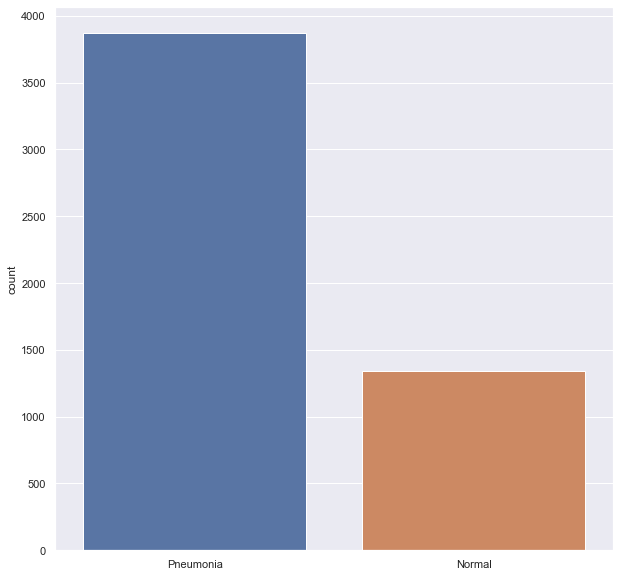

In [67]:
import seaborn as sns
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

The data seems imbalanced . To increase the no. of training examples, we will use data augmentation

Text(0.5, 1.0, 'NORMAL')

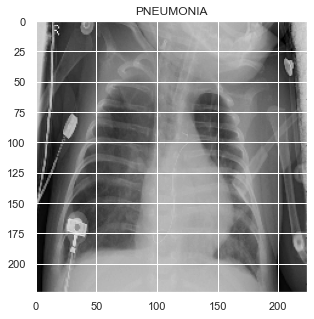

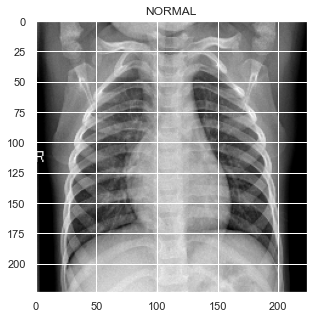

In [68]:
#Previewing the images of both the classes
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

Next I displayed some normal and pneumonia images to just have a look at how much different they look from the naked eye.

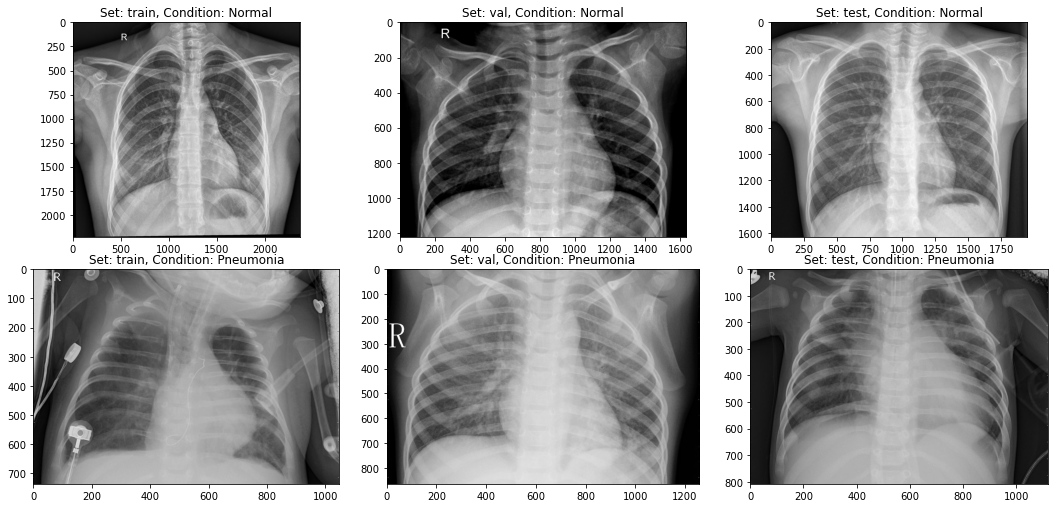

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
input_path = '/Users/dammy/Downloads/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

we will import our VGG16 model. While importing we will use the weights of the imageNet & include_top=False signifies that we do not want to classify 1000 different categories present in imageNet our problem is all about two categories Pneumonia and Normal that’s why we are just dropping the first and last layers then we will just design our own layers and add it into VGG16.

In [38]:
vgg_model = VGG16(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

After importing VGG16 model, we have to make this important change. By using the for loop iterating over all layers and setting the trainable as False, so that all the layers would not be trained.

In [39]:
for each_layer in vgg_model.layers:
    each_layer.trainable = False

We will try to see how many classes are present in our train dataset to understand how many output labels we should have.

In [40]:
classes = glob('/Users/dammy/Downloads/chest_xray/train/*') 

As we deleted the first and the last columns in the previous step, We will just make a flattened layer and finally we just add our last layer with a softmax activation function. len(classes) indicate how many categories we have in our output layer. 

In [41]:

flatten_layer = Flatten()(vgg_model.output)
prediction = Dense(len(classes), activation='softmax')(flatten_layer)

Now we will combine the VGG output and prediction, this all together will create a model. When we check the model summary we can observe that the last layer have only two categories.

In [42]:

final_model = Model(inputs=vgg_model.input, outputs=prediction) 
final_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Now we will compile our model using adam optimizer and optimization metric as accuracy.

In [43]:
final_model.compile( 
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Data Augmentation


In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

After compiling the model, we have to import our dataset to Keras using ImageDataGenerator in Keras. For creating additional features we use metrics like rescale, shear_range, zoom_range these will help us in the training and testing phases.

In [44]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
testing_datagen = ImageDataGenerator(rescale =1. / 255)

Now we will insert the images using flow_from_directory() function. Make sure that here we have to pass the same image size as we initiated earlier. Batch size 4 indicates that at once 4 images will be given for training. Class_mode is Categorical i.e either Pneumonia or Not Pneumonia.

In [45]:
training_set = train_datagen.flow_from_directory('/Users/dammy/Downloads/chest_xray/train', 
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [46]:
test_set = testing_datagen.flow_from_directory('/Users/dammy/Downloads/chest_xray/test',
                                               target_size = (224, 224),
                                               batch_size = 4,
                                               class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [47]:
fitted_model = final_model.fit_generator( 
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
1304/1304 [==============================] - 2710s 2s/step - loss: 0.3370 - accuracy: 0.9164 - val_loss: 1.1921e-07 - val_accuracy: 0.7837
Epoch 2/10
1304/1304 [==============================] - 2732s 2s/step - loss: 0.2764 - accuracy: 0.9381 - val_loss: 0.0101 - val_accuracy: 0.7997
Epoch 3/10
1304/1304 [==============================] - 1839s 1s/step - loss: 0.2358 - accuracy: 0.9534 - val_loss: 6.2875e-05 - val_accuracy: 0.9103
Epoch 4/10
1304/1304 [==============================] - 1980s 2s/step - loss: 0.2115 - accuracy: 0.9597 - val_loss: 2.8102e-05 - val_accuracy: 0.8910
Epoch 5/10
1304/1304 [==============================] - 1917s 1s/step - loss: 0.2226 - accuracy: 0.9590 - val_loss: 0.0036 - val_accuracy: 0.9103
Epoch 6/10
1304/1304 [==============================] - 25170s 19s/step - loss: 0.2001 - accuracy: 0.9626 - val_loss: 1.5819e-04 - val_accuracy: 0.8686
Epoch 7/10
1304/1304 [==============================] - 6438s 5s/step - loss: 0.2152 - accuracy: 0.9611 - 

In [48]:
final_model.save('our_model3.h5')

In [59]:
from keras_preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np
model=load_model('our_model3.h5') #Loading our model
img=image.load_img('/Users/dammy/Downloads/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg',target_size=(224,224))
imagee=image.img_to_array(img) #Converting the X-Ray into pixels
imagee=np.expand_dims(imagee, axis=0)
img_data=preprocess_input(imagee)
prediction=model.predict(img_data)
result = int(prediction[0][0])
# if prediction[0][0]>prediction[0][1]: #Printing the prediction of model.
# 	print('Person is safe.')
# else:
# 	print('Person is affected with Pneumonia.')
if result==0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")
print(f'Predictions: {result}')


Person is Affected By PNEUMONIA
Predictions: 0


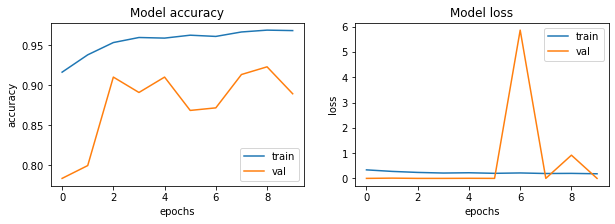

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(fitted_model.history[met])
    ax[i].plot(fitted_model.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

So far so good. The model is converging which can be observed from the decrease in loss and validation loss with epochs. Also it is able to reach 88% validation accuracy in 10 epochs.

In [53]:
final_model.evaluate(test_set)

156/156 [==============================] - 232s 1s/step


[0.05424731969833374, 0.8894230723381042]

In [55]:
# I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
import cv2
import os

test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (224, 224))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)



[[161  73]
 [  2 388]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       234
           1       0.84      0.99      0.91       390

   micro avg       0.88      0.88      0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.90      0.88      0.87       624



<AxesSubplot:>

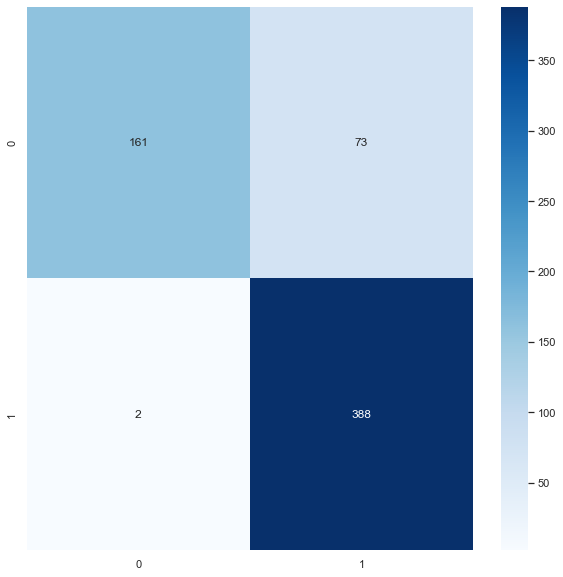

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
predictions = model.predict(test_data)

y_pred = np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, y_pred))
cm = confusion_matrix(test_labels, y_pred)
report = classification_report(test_labels, y_pred)
print(report)
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(cm, cmap= "Blues", annot=True, fmt='', linecolor = 'black')
